In [24]:
# 必要なライブラリをインポート
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sympy as sp
import random
import sys
import copy
from math import comb
from matplotlib.gridspec import GridSpec
from scipy.stats import poisson
import seaborn as sns
import time
import datetime
import os
import ast
import csv

# プロジェクトのsrcディレクトリをimportパスに追加
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
    
from utils import *
from ebcm import *

# グラフ全体のフォント設定
plt.rcParams['font.family'] = 'serif'  # 全体のフォントをSerifに設定
plt.rcParams['mathtext.fontset'] = 'cm'  # 数式のフォントをComputer Modernに設定
plt.rcParams['mathtext.rm'] = 'serif'  # TeXの通常フォントをSerifに設定
plt.rcParams['font.size'] = 18  # デフォルトフォントサイズ
plt.rcParams['axes.labelsize'] = 18  # 軸ラベルのフォントサイズ
plt.rcParams['axes.titlesize'] = 22  # タイトルのフォントサイズ
plt.rcParams['legend.fontsize'] = 16  # 凡例のフォントサイズ
plt.rcParams['grid.color'] = 'gray'  # グリッドの色を薄い灰色に設定
plt.rcParams['grid.linestyle'] = ':'  # グリッドを点線に設定
plt.rcParams['grid.linewidth'] = 0.5  # グリッドの線幅を設定

/Users/mikamikojirou/Downloads/network-SAR-EBCM/src


In [89]:
def load_simulation_parameters(file_path):
    """
    parameters.csv の内容を読み込み、パラメータを辞書として返す。
    
    CSV ファイルのフォーマット:
        Parameter,Type,Value
    例:
        Network,String,ER
        V,Integer,10000
        kAve,Double,10.0
        tmax,Integer,100
        iterations,Integer,50
        p,Double,0.2
        ta,Integer,"1"
        tb,Integer,"4"
        initialAdoptionRate,Double,0.0001
        gamma,Double,1.0
    
    Returns:
        dict: パラメータ名をキーとする辞書
    """
    params = {}
    with open(file_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            key = row['Parameter']
            value_str = row['Value']
            print(f'key: {key}, value_str: {value_str}')
            try:
                value = ast.literal_eval(value_str)
            except Exception:
                value = value_str
            params[key] = value
    return params

def load_simulation_args(file_path):
    """
    シミュレーション引数（alphaValues, lambdaValues, iterations, maxTime）を args.csv から読み込む。
    
    ファイルフォーマット:
      alphaValues,lambdaValues,iterations,maxTime
      "[0.0, 0.01, ...]","[0.0, 0.01, ...]",1000,100

    Returns:
        alpha_values (np.ndarray): α の値の配列
        lambda_values (np.ndarray): λ の値の配列
        iterations (int): 1バッチあたりの反復回数（ネットワーク反復×シミュレーション反復）
        max_time (int): シミュレーションの最大時刻（時刻 0～max_time の max_time+1 個のデータ）
    """
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        row = next(reader)
        alpha_str, lambda_str, iterations_str, max_time_str = row
        alpha_values = np.array(ast.literal_eval(alpha_str))
        lambda_values = np.array(ast.literal_eval(lambda_str))
        iterations = int(iterations_str)
        max_time = int(max_time_str)
    return alpha_values, lambda_values, iterations, max_time

def load_simulation_result(file_pattern, num_alpha, num_lambda, iterations, max_time, results_dir=""):
    """
    指定したバッチ番号のシミュレーション結果 CSV を読み込み、4次元配列に変形する。
    
    ファイル名は file_pattern から ".csv" を除き、batch_number を付加したものとする。
    例: "s_all_results.csv" → "s_all_results1.csv", "s_all_results2.csv", ...
    
    Args:
        file_pattern (str): 出力ファイルの基本名（例："s_all_results.csv"）
        batch_number (int): バッチ番号（1-indexed）
        num_alpha (int): α の個数
        num_lambda (int): λ の個数
        iterations (int): 1バッチあたりの反復回数
        max_time (int): シミュレーションの最大時刻（記録は 0～max_time、サイズは max_time+1）
        results_dir (str): CSV ファイルが存在するディレクトリ（省略時はカレントディレクトリ）
    
    Returns:
        np.ndarray: 形状 (num_alpha, num_lambda, iterations, max_time+1) のデータ配列
    """
    filename = file_pattern.replace(".csv", "") + ".csv"
    file_path = os.path.join(results_dir, filename)

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} not found.")

    # CSV は 1 列 ("value") のみ。ヘッダーをスキップして読み込み
    data = np.loadtxt(file_path, delimiter=',', skiprows=1, dtype=int)
    try:
        data = data.reshape(num_alpha, num_lambda, iterations, max_time+1)
    except ValueError as e:
        raise ValueError(f"Data in {file_path} cannot be reshaped to "
                         f"({num_alpha}, {num_lambda}, {iterations}, {max_time+1}): {e}")
    return data

def load_all_batches(file_pattern, num_alpha, num_lambda, iterations, max_time, results_dir=""):
    """
    複数バッチ分のシミュレーション結果を読み込み、反復軸方向に連結する。
    
    Args:
        file_pattern (str): 出力ファイルの基本名（例："s_all_results.csv"）
        num_batches (int): バッチ数
        num_alpha (int): α の個数
        num_lambda (int): λ の個数
        iterations (int): 1バッチあたりの反復回数
        max_time (int): シミュレーションの最大時刻（0～max_time、サイズは max_time+1）
        results_dir (str): CSV ファイルが存在するディレクトリ（デフォルトはカレントディレクトリ）
        
    Returns:
        np.ndarray: 形状 (num_alpha, num_lambda, num_batches*iterations, max_time+1) の連結データ
    """
    total_iterations = num_batches * iterations
    concatenated_data = np.empty((num_alpha, num_lambda, total_iterations, max_time+1), dtype=int)
    current_iter_index = 0

    batch_data = load_simulation_result(file_pattern, num_alpha, num_lambda, iterations, max_time, results_dir)
    concatenated_data[:, :, current_iter_index:current_iter_index+iterations, :] = batch_data
    current_iter_index += iterations
    # for batch in range(1, num_batches + 1):
    #     batch_data = load_simulation_result(file_pattern, batch, num_alpha, num_lambda, iterations, max_time, results_dir)
    #     concatenated_data[:, :, current_iter_index:current_iter_index+iterations, :] = batch_data
    #     current_iter_index += iterations
    return concatenated_data

if __name__ == "__main__":
    # 結果ファイルが保存されているディレクトリ（Java 側と合わせる）
    results_directory = os.path.abspath(os.path.join('..', '..', 'simulation_results/'))

    # ------------------ シミュレーションパラメータの読み込み ------------------
    params_file_path = results_directory + "/parameters.csv"
    simulation_params = load_simulation_parameters(params_file_path)
    print("Simulation Parameters:")
    for key, value in simulation_params.items():
        print(f"  {key}: {value}")

    # ------------------ シミュレーション引数の読み込み ------------------
    args_file_path = results_directory + "/args.csv"
    alpha_values, lambda_values, iterations, max_time = load_simulation_args(args_file_path)
    print("\nSimulation Args:")
    print("Alpha values:", alpha_values)
    print("Lambda values:", lambda_values)
    print("Iterations per batch:", iterations)
    print("Max time:", max_time)
    
    # ------------------ シミュレーション結果の読み込み ------------------
    num_batches = 1
    num_alpha = len(alpha_values)
    num_lambda = len(lambda_values)
    
    # all の結果を全バッチ分読み込み、連結する
    aa_results = load_all_batches("aa_all_results.csv", num_alpha, num_lambda, iterations, max_time, results_directory)
    ab_results = load_all_batches("ab_all_results.csv", num_alpha, num_lambda, iterations, max_time, results_directory)
    r_results = load_all_batches("r_all_results.csv", num_alpha, num_lambda, iterations, max_time, results_directory)
    print("r_all shape:", r_results.shape)


key: Network, value_str: ER
key: numVertices, value_str: 10000
key: averageDegree, value_str: 10.0
key: maxTime, value_str: 100
key: iterations, value_str: 200
key: p, value_str: 0.2
key: ta, value_str: 1
key: tb, value_str: 4
key: initialAdoptionRate, value_str: 1.0E-4
key: gamma, value_str: 1.0
Simulation Parameters:
  Network: ER
  numVertices: 10000
  averageDegree: 10.0
  maxTime: 100
  iterations: 200
  p: 0.2
  ta: 1
  tb: 4
  initialAdoptionRate: 0.0001
  gamma: 1.0

Simulation Args:
Alpha values: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1]
Lambda values: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Iterations per batch: 200
Max time: 100
r_all shape: (12, 11, 200, 101)


In [79]:
### シミュレーションのパラメーター ###

# 文字列パラメーター
network = str(simulation_params['Network'])

# 整数パラメーター
N = int(simulation_params['numVertices'])
z = int(simulation_params['averageDegree'])
iterations = int(simulation_params['iterations'])
t_range = int(simulation_params['maxTime'])

# 浮動小数点パラメーター
gamma = float(simulation_params['gamma'])
p = float(simulation_params['p'])

# その後、各要素を int にキャストしてタプルに変換
t_pair = [1, 4]

# バッチ数が決まっている場合など
itr = iterations * num_batches

# p_list の例
p_list = [p, 1.0 - p]

# rho0 = 1.0 / N (頂点数 N で割る)
rho0 = 1.0 / float(N)


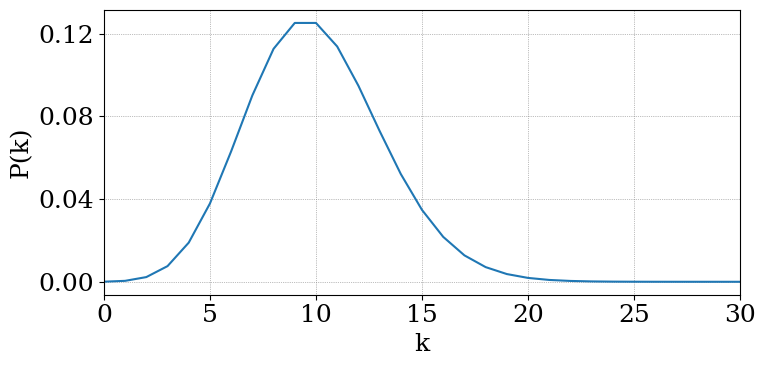

In [37]:
pk_poi = poisson.pmf(np.arange(N), z)
lowest_degree_for_ana=1
highest_degree_for_ana=N-1
k_vals_for_ana = np.arange(1, 3*z)

#p(k)の描画
degree = np.arange(N)
plt.figure(figsize=(8,4))
plt.plot(degree, pk_poi)

# グラフの設定
plt.xlabel('k')
plt.ylabel('P(k)')
plt.xlim(0,3*z)
plt.grid(True, linestyle=':')
plt.yticks(np.arange(0, 0.14, 0.04))
plt.tight_layout()

# グラフを表示
plt.show()

In [51]:
# 初期条件
dt = 1
time_steps = (t_range + 1) / dt
times_con = np.arange(0, time_steps * dt, dt)

# 2次元配列の準備
theta_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
q_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
sl_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
sh_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
aa_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
ab_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
ra_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
rb_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))

# ルンゲクッタ法で解を求める
for alpha_idx, alpha in enumerate(alpha_values):
    for lamb_idx, lamb in enumerate(lambda_values):
        y0 = [1, 1, 1 - rho0, 1 - rho0, rho0, rho0, 0, 0]
        result = runge_kutta4(sar_derivatives, y0, times_con, lamb, gamma, rho0, p, alpha, k_vals_for_ana, pk_poi, z, t_pair)
        theta, q, sl, sh, aa, ab, ra, rb = result.T

        # 結果を保存
        theta_t_ana[alpha_idx, lamb_idx, :] = theta
        q_t_ana[alpha_idx, lamb_idx, :] = q
        sl_t_ana[alpha_idx, lamb_idx, :] = sl
        sh_t_ana[alpha_idx, lamb_idx, :] = sh
        aa_t_ana[alpha_idx, lamb_idx, :] = aa
        ab_t_ana[alpha_idx, lamb_idx, :] = ab
        ra_t_ana[alpha_idx, lamb_idx, :] = ra
        rb_t_ana[alpha_idx, lamb_idx, :] = rb

In [72]:
r_t_ana = p * ra_t_ana + (1 - p) * rb_t_ana

In [53]:
aa_results_ave = np.mean(aa_results, axis=2) / p_list[0]/N
ab_results_ave = np.mean(ab_results, axis=2) / p_list[1]/N
r_results_ave = np.mean(r_results, axis=2) / N

aa_results_std = np.std(aa_results, axis=2) / p_list[0]/N
ab_results_std = np.std(ab_results, axis=2) / p_list[1]/N
r_results_std = np.std(r_results, axis=2) / N

In [100]:
# 平均と標準偏差を格納する配列の初期化
shape = (len(alpha_values), len(lambda_values), t_range+1)
aa_results_ave_valid = np.zeros(shape)
ab_results_ave_valid = np.zeros(shape)
a_results_ave_valid = np.zeros(shape)
r_results_ave_valid = np.zeros(shape)

aa_results_std_valid = np.zeros(shape)
ab_results_std_valid = np.zeros(shape)
a_results_std_valid = np.zeros(shape)
r_results_std_valid = np.zeros(shape)

# 各 alpha と lambda の組み合わせについて計算
for alpha_idx, alpha in enumerate(alpha_values):
    for lamb_idx, lamb in enumerate(lambda_values):
        valid = []
        # 有効なイテレーションを抽出
        for iteration in range(itr):
            if r_results[alpha_idx, lamb_idx, iteration, -1] > 20:
                valid.append(iteration)
        
        if valid:
            # 有効なデータを抽出
            aa_valid = aa_results[alpha_idx, lamb_idx, valid, :]
            ab_valid = ab_results[alpha_idx, lamb_idx, valid, :]
            r_valid = r_results[alpha_idx, lamb_idx, valid, :]
            
            # 平均と標準偏差を計算し、Vとp_listで割る
            aa_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(aa_valid, axis=0) / N / p_list[0]
            ab_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(ab_valid, axis=0) / N / p_list[1]
            r_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(r_valid, axis=0) / N
            
            aa_results_std_valid[alpha_idx, lamb_idx, :] = np.std(aa_valid, axis=0) / N / p_list[0]
            ab_results_std_valid[alpha_idx, lamb_idx, :] = np.std(ab_valid, axis=0) / N / p_list[1]
            r_results_std_valid[alpha_idx, lamb_idx, :] = np.std(r_valid, axis=0) / N
        else:
            # 有効なイテレーションがない場合、全イテレーションを対象に計算
            aa_valid = aa_results[alpha_idx, lamb_idx, :, :]
            ab_valid = ab_results[alpha_idx, lamb_idx, :, :]
            r_valid = r_results[alpha_idx, lamb_idx, :, :]
            
            # 平均と標準偏差を計算し、Vとp_listで割る
            aa_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(aa_valid, axis=0) / N / p_list[0]
            ab_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(ab_valid, axis=0) / N / p_list[1]
            r_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(r_valid, axis=0) / N
            
            aa_results_std_valid[alpha_idx, lamb_idx, :] = np.std(aa_valid, axis=0) / N / p_list[0]
            ab_results_std_valid[alpha_idx, lamb_idx, :] = np.std(ab_valid, axis=0) / N / p_list[1]
            r_results_std_valid[alpha_idx, lamb_idx, :] = np.std(r_valid, axis=0) / N

# 結果の確認
print("平均の形状:", aa_results_ave_valid.shape)
print("標準偏差の形状:", aa_results_std_valid.shape)

平均の形状: (12, 11, 101)
標準偏差の形状: (12, 11, 101)


In [101]:
alpha_idx_list = [0, 4]
lamb_idx_list = [7, 9]

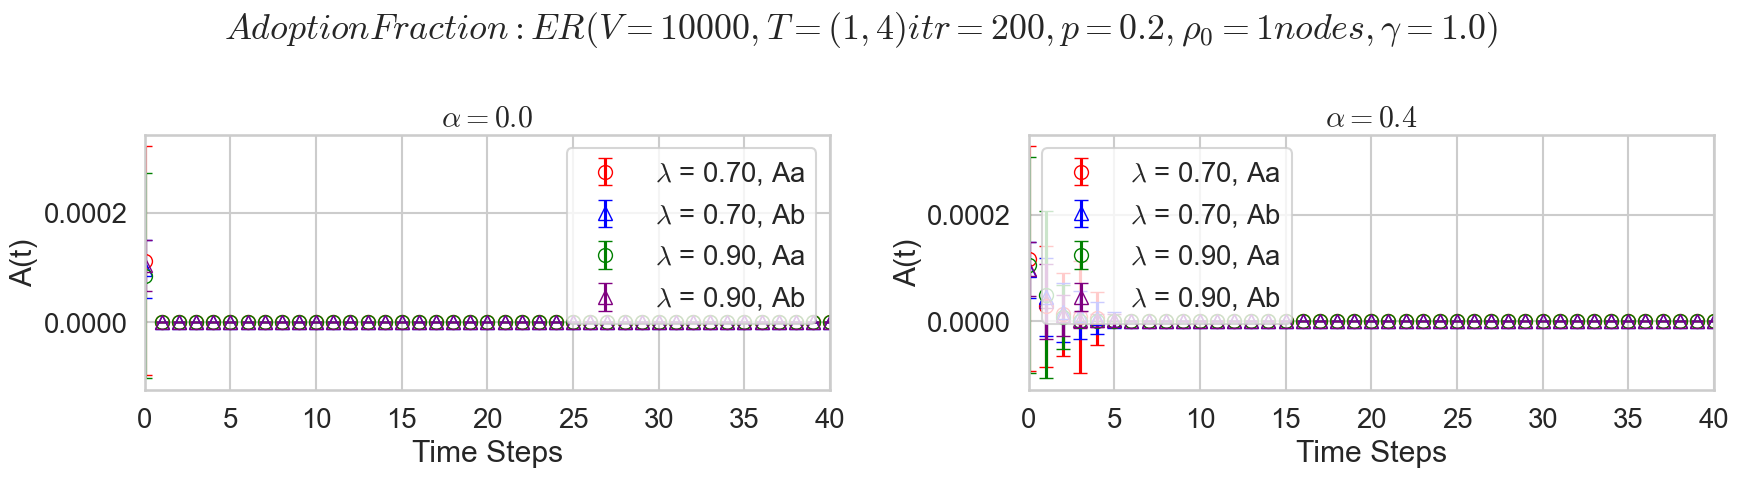

In [102]:
overall_times = np.arange(0, t_range + 1, 1)
plt.figure(figsize=(18, 5))
plt.suptitle(rf'$Adoption Fraction: {network} (V={N}, T={tuple(t_pair)}itr={itr}, p={p}, \rho_0={int(rho0 * N)}nodes, \gamma={gamma})$')
colors = ['red', 'blue', 'green', 'purple']

for a, alpha_idx in enumerate(alpha_idx_list):
    alpha = alpha_values[alpha_idx]
    plt.subplot(1, len(alpha_idx_list), a + 1)
    color_idx = 0
    for lamb_idx in lamb_idx_list:
        lamb = lambda_values[lamb_idx]
        # Aa の結果
        plt.errorbar(overall_times,
                    aa_results_ave_valid[alpha_idx, lamb_idx],
                    yerr=aa_results_std_valid[alpha_idx, lamb_idx],
                    capsize=5,
                    fmt='o',
                    markerfacecolor='none',
                    markeredgecolor=colors[color_idx], 
                    ecolor=colors[color_idx],
                    markersize=10,
                    label=rf'$\lambda$ = {lamb:.2f}, Aa')
        
        # Aa のEBCMによる近似
        # plt.plot(times_con,
        #             aa_t_ana[alpha_idx][lamb_idx],
        #             linestyle='-',
        #             linewidth=2,
        #             color=colors[color_idx])

        # Ab の結果
        plt.errorbar(overall_times,
                    ab_results_ave_valid[alpha_idx, lamb_idx],
                    yerr=ab_results_std_valid[alpha_idx, lamb_idx],
                    capsize=5,
                    fmt='^',
                    markerfacecolor='none',
                    markeredgecolor=colors[color_idx + 1], 
                    ecolor=colors[color_idx + 1],
                    markersize=10,
                    label=rf'$\lambda$ = {lamb:.2f}, Ab')

        # Ab のEBCMによる近似
        # plt.plot(times_con,
        #             ab_t_ana[alpha_idx][lamb_idx],
        #             linestyle='-',
        #             linewidth=2,
        #             color=colors[color_idx + 1])

        color_idx += 2
    plt.xlabel('Time Steps')
    plt.ylabel('A(t)')
    plt.xlim(0, 40)
    # plt.ylim(0,0.25)
    plt.title(rf'$\alpha={alpha}$')
    plt.legend(loc='best')  # ラベルを表示
    plt.grid(True)  # グリッドを表示

plt.tight_layout()  # suptitle を考慮
plt.show()

In [96]:
# 平均と標準偏差を格納する配列の初期化
shape = (len(alpha_values), len(lambda_values), t_range+1)
r_results_ave_valid = np.zeros(shape)
r_results_std_valid = np.zeros(shape)

# 各 alpha と lambda の組み合わせについて計算
for alpha_idx, alpha in enumerate(alpha_values):
    for lamb_idx, lamb in enumerate(lambda_values):
        valid = []
        # 有効なイテレーションを抽出
        for iteration in range(itr):
            if r_results[alpha_idx, lamb_idx, iteration, -1] > 20:
                valid.append(iteration)
        
        if valid:
            # 有効なデータを抽出
            r_valid = r_results[alpha_idx, lamb_idx, valid, :]
            
            # 平均と標準偏差を計算し、Vとp_listで割る
            r_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(r_valid, axis=0) / N
            r_results_std_valid[alpha_idx, lamb_idx, :] = np.std(r_valid, axis=0) / N
        else:
            # 有効なイテレーションがない場合、全イテレーションを対象に計算
            r_valid = r_results[alpha_idx, lamb_idx, :, :]
            
            # 平均と標準偏差を計算し、Vとp_listで割る
            r_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(r_valid, axis=0) / N
            r_results_std_valid[alpha_idx, lamb_idx, :] = np.std(r_valid, axis=0) / N

# 結果の確認
print("平均の形状:", r_results_ave_valid.shape)
print("標準偏差の形状:", r_results_std_valid.shape)

平均の形状: (12, 11, 101)
標準偏差の形状: (12, 11, 101)


/var/folders/x_/xh9wlw410pvfbxgn1v4jp1300000gn/T/ipykernel_66696/2032046118.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


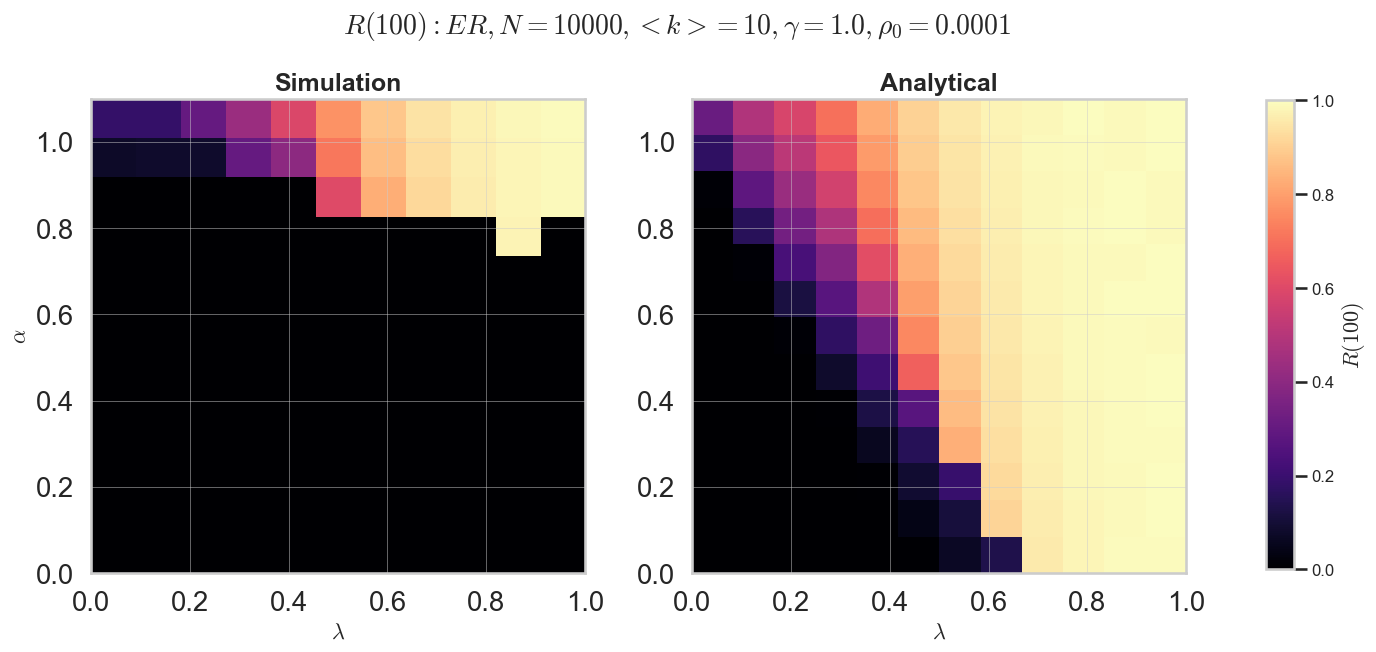

In [97]:
# Seabornスタイルを使用
sns.set_context("talk", font_scale=1.2)
sns.set_style("whitegrid")

# 図の準備
fig = plt.figure(figsize=(14, 7))
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

# カラーマップの範囲を統一
vmin = 0
vmax = 1

# サブプロット1: シミュレーション結果
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(
    r_results_ave_valid[:,:,-1],
    extent=[0.0, 1.0, 0.0, 1.1],
    origin='lower',
    aspect='auto',
    cmap='magma',
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("Simulation", fontsize=18, weight='bold')
ax1.set_xlabel(r"$\lambda$", fontsize=16)
ax1.set_ylabel(r"$\alpha$", fontsize=16, weight='bold')
ax1.grid(linewidth=0.5, alpha=0.7)  # グリッドを細く

# サブプロット2: 理論結果
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(
    r_t_ana[:,:,-1],
    extent=[0.0, 1.0, 0.0, 1.1],
    origin='lower',
    aspect='auto',
    cmap='magma',
    vmin=vmin,
    vmax=vmax
)
ax2.set_title("Analytical", fontsize=18, weight='bold')
ax2.set_xlabel(r"$\lambda$", fontsize=16, weight='bold')
ax2.set_ylabel("")
ax2.grid(linewidth=0.5, alpha=0.7)  # グリッドを細く

# # カラーバーを全体で共有
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.67])  # 位置: [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(rf"$R({t_range})$", fontsize=16, weight='bold')
cbar.ax.tick_params(labelsize=12)

# 全体のタイトル
plt.suptitle(rf"$R({t_range}): {network}, N={N}, <k>={z}, \gamma={gamma}, \rho_0={rho0}$", fontsize=20, weight='bold', y=0.95)

# レイアウト調整
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
